In [40]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict , Literal
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel
from pprint import pprint

In [34]:
load_dotenv()
llm= ChatGoogleGenerativeAI(model= 'gemini-2.5-flash-lite') # This is very light weight model

In [35]:
class Output_validation(BaseModel):
    response: Literal['Positive', 'Negative']

In [36]:
validated_model= llm.with_structured_output(Output_validation)

In [37]:
class Sentiment(TypedDict):
    message: str
    analysis: str 
    results : str

    reasons: str

In [38]:
def sentiment_a(state: Sentiment) -> Sentiment:
    output= validated_model.invoke(f'''Find the sentiment of the {state['message']}''').response # We ensure that only 'Pos' or 'Neg'
    return {'analysis':output}

def positive_respond(state: Sentiment) -> Sentiment:
    output= llm.invoke('Generate a very short within 30 words thank you message to user for positive feedback')
    return {'results': output}

def negative_reasons(state: Sentiment) -> Sentiment:
    output= llm.invoke(f"Analysis and find out some main reason from the given message that why user's feedback is negative ... Message : {state['message']} ... Reason should be in 20-30 words")
    return {'reasons': output}

def negative_respond(state: Sentiment) -> Sentiment:
    output= llm.invoke(f'Our user give us negative feedback due to these reasons - {state['reasons']} \n Generate a short message within 50 words that target the to solve the reasons and make the user happy so user cannot leave our platform')
    return {'results': output}

def condition_selection(state: Sentiment) -> Literal['positive_o', 'Negative_reason']:
    user_response= state['analysis']
    
    if user_response.lower() == 'positive':
        return 'positive_o'
    else:
        return 'Negative_reason'



{'analysis': 'Negative',
 'message': 'I bought this “AI-powered smart toaster” thinking it would '
            'simplify my mornings. Instead, I now negotiate with a touchscreen '
            'just to get a slice of bread toasted. It has Wi-Fi, Bluetooth, '
            'and a mood ring — but somehow forgets what golden brown looks '
            'like. One morning it asked me to update its firmware before it '
            'would toast. Another time it sent a push notification to my phone '
            'saying “Your toast is ready” — while the bread was still cold.\n'
            'It has 12 modes, none of which include “just toast it.” I tried '
            'the “artisan crisp” setting and got a slice that looked like it '
            'survived a forest fire. The voice assistant inside keeps asking '
            'if I want to sync my breakfast schedule with my calendar. No, I '
            'just want toast. Not a TED Talk.\n'
            "If you want a toaster that gaslights you into thi

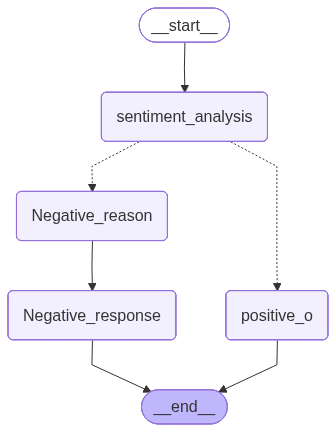

In [43]:
graphs= StateGraph(Sentiment)
graphs.add_node('sentiment_analysis', sentiment_a)
graphs.add_node('positive_o',positive_respond)
graphs.add_node('Negative_reason',negative_reasons)
graphs.add_node('Negative_response' ,negative_respond)

graphs.add_edge(START , 'sentiment_analysis')
graphs.add_conditional_edges('sentiment_analysis',condition_selection)
graphs.add_edge('positive_o' , END)
graphs.add_edge('Negative_reason', 'Negative_response')
graphs.add_edge('Negative_response', END)

workflow= graphs.compile()

user_message= {'message':'''I bought this “AI-powered smart toaster” thinking it would simplify my mornings. Instead, I now negotiate with a touchscreen just to get a slice of bread toasted. It has Wi-Fi, Bluetooth, and a mood ring — but somehow forgets what golden brown looks like. One morning it asked me to update its firmware before it would toast. Another time it sent a push notification to my phone saying “Your toast is ready” — while the bread was still cold.
It has 12 modes, none of which include “just toast it.” I tried the “artisan crisp” setting and got a slice that looked like it survived a forest fire. The voice assistant inside keeps asking if I want to sync my breakfast schedule with my calendar. No, I just want toast. Not a TED Talk.
If you want a toaster that gaslights you into thinking you're the problem, this is it. Otherwise, stick to the ₹800 one from the local market. At least that one doesn't judge your bread choices.
'''}
system_message= workflow.invoke(user_message)

pprint(system_message)
graphs.compile()

In [46]:
pprint(system_message['reasons'].content)

('The toaster is overly complicated, unreliable, and fails at its basic '
 'function. Its "smart" features are intrusive and frustrating, making a '
 'simple task difficult.')


In [49]:
pprint(system_message['results'].content)

("We're sorry your toaster experience was frustrating. We're working to "
 'simplify its features and improve reliability. Your feedback is crucial, and '
 "we're committed to making your experience better. Please give us another "
 'chance to impress you!')
